# An Investigation of Linear Concept Approximation

This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations.
(Marc Lenz, 2021)


** **

## Linear Concept Approximation in General

**What is Linear Concept Approximation?**
- Method for Cross-Lingual information Retrieval. For two documents in different languages, lets say:
$d_{x=english},d_{y= french}$ we create vector representations $\bar{d_{x}} \in \mathbb{R}^{n} , \bar{d_{y} \in \mathbb{R}^{n_{x}}}$. Then we train a mapping from the english vector represenations to the french, $\theta: \mathbb{R}^{n}\rightarrow \mathbb{R}^{n}$. Where $ cos(\theta(\bar{d_{x=english}}), \bar{d_{y_french}})$ will give a good similarity measure.

**How is it computed?**

Given two sets of aligned documents $D_{x},D_{y}$ of two different Languages $L_{x}, L_{y}$,
we first create the Bag of Words (BOW) of each document for their respective language. 
This yields two sets of high-dimensional vectors. We convert these into matrices: $X\in \mathbb{R}^{n_{x}},Y\in \mathbb{R}^{n_{y}}$. Where the ith column of X,Y is the ith BOW vector of $d_{x,i}$
Followed by that we compute the r-truncted singular value decomposition of X and Y:
$X_{*k} = U \Sigma V_{*k}$ , same for Y.

Then, in the second step we want to find a mapping $\theta: X_{*k} \rightarrow Y_{*k}$, $\theta$ linear.
We use the least square loss $||X\theta-Y||_{2}^{2}$

##  1. Load Preprocessed Dataset

The original JRC-Arquis dataset have been preprocessed before. 
The aligned documents have been saved in two seperate csv files. 
For details of the preprocessing, check: read_and_preprocess.py

In [1]:
from Utils import read_docs
from sklearn.model_selection import train_test_split

# parse an xml file by name
french_docs, english_docs = read_docs('Data/jrq_aligned_10000_fr.csv', 'Data/jrq_aligned_10000_en.csv')
fr_docs_train, fr_docs_test, en_docs_train, en_docs_test = train_test_split(french_docs, english_docs, 
                                                                            test_size=0.1, random_state = 42)

print("Number of training Documents: "+ str(len(fr_docs_train)))
print("Number of test Documents: "+ str(len(fr_docs_test)))

Number of training Documents: 8759
Number of test Documents: 974


## 2.Training of Linear Concept Approximation
- Train LSI for different sample sizes and dimensions


In [2]:
from Utils import dict_combinations
from Utils import Vector_Lsi_Model, LCA_Model
import random 

sample_sizes = [1000, 2000, 3000, 4000, 5000, 6000]
dimensions = [100, 200, 300, 400, 500, 600, 700, 800]

#Creates List of Parameter Dictonaries
lsi_model_params = dict_combinations({"sample_size": sample_sizes, 
                                      "dimension" : dimensions})

#Train LSI Models with the given parameter list
lca_models = []
for param in lsi_model_params:
    
    #Get random sample
    sample_size = param["sample_size"]
    training_docs = list(zip(en_docs_train, fr_docs_train))
    random.shuffle(training_docs)
    en_docs_train_shuffled, fr_docs_train_shuffled = zip(*training_docs)
    sample_en = en_docs_train_shuffled[:sample_size]
    sample_fr = fr_docs_train_shuffled[:sample_size]
    
    #Now train models
    lsi_model_en = Vector_Lsi_Model(sample_en, dimension = param["dimension"])
    lsi_model_fr = Vector_Lsi_Model(sample_fr, dimension = param["dimension"])
    lca = LCA_Model(sample_en, sample_fr, lsi_model_en, lsi_model_fr)
    lca_models.append(lca)

## Evaluation
- Train LSI for different sample sizes and dimensions

In [3]:
from Utils import mate_retrieval_score

scores = []
for lca_model in lca_models:
    env = lca_model.create_embeddings(en_docs_test, language= "l1")
    frv = lca_model.create_embeddings(fr_docs_test, language= "l2")
    score = mate_retrieval_score(env, frv)
    scores.append(score)

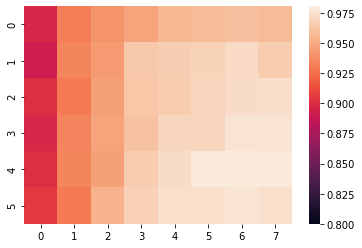

In [9]:
import numpy as np
import seaborn as sns


score_matrix = np.asarray(scores).reshape(len(sample_sizes),len(dimensions))
ax = sns.heatmap(score_matrix, vmin=0.8)

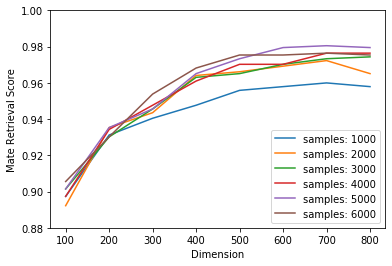

In [8]:
import matplotlib.pyplot as plt

for k in range(len(sample_sizes)):
    plt.plot(dimensions,score_matrix[k], label="samples: "+str(sample_sizes[k]))
plt.xlabel("Dimension")
plt.ylabel("Mate Retrieval Score")
plt.ylim((0.88,1))
plt.legend()

## Linear Concept Approximation from the viewpoint of Statistical Learning Theory

**Eckardt Young Theorem:**
for $n\geq r$ and $X\in \mathbb{R}^{n \times n}$

$argmin_{\bar{X}: rank(\bar{X})=d}||X-\bar{X_{|d}}||_{2}= U \Sigma V_{*d}$

- In general: larger d $\implies$ better matrix approximation

also: $Var(X) = Var(U \Sigma V_{*d}) = Var(\Sigma)=\sum_{k=1}^{d} \sigma_{k}$

Linear Regression:
- $\hat{\theta} = \frac{1}{n}[X \theta - Y]_{2}^{2}$
- Following a proof from https://web.stanford.edu/class/cs229t/notes.pdf, the following holds:
$\mathbb{E}[L(\hat{\theta})-L(\theta^{*})]= \frac{d\sigma^{2}}{n}$

So in this context, that means: $\mathbb{E}[L(\hat{\theta})-L(\theta^{*})]= \frac{d}{n}\sum_{k=1}^{d} \sigma_{k}$

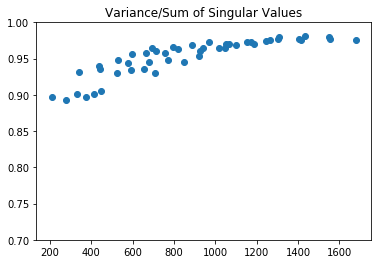

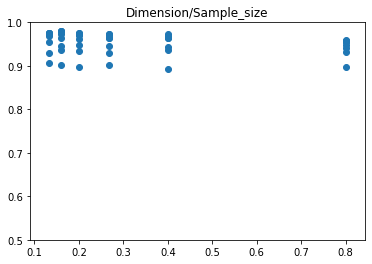

In [6]:
excess_losses = []
for k in range(len(lca_models)):
    lca_model = lca_models[k]
    singular_vals = lca_model.l1_lsi_model.lsi_model.projection.s
    sum_singular_vals = np.sum(singular_vals)
    dimension = lca.l1_lsi_model.dimension
    burden = sum_singular_vals*dimension
    sample_size = lsi_model_params[k]["sample_size"]
    excess_losses.append(sum_singular_vals)
    
plt.scatter(excess_losses, scores)
plt.ylim((0.7,1))
plt.title("Variance/Sum of Singular Values")
plt.show()
    
    
excess_losses = []
for k in range(len(lca_models)):
    lca_model = lca_models[k]
    singular_vals = lca_model.l1_lsi_model.lsi_model.projection.s
    sum_singular_vals = np.sum(singular_vals)
    dimension = lca.l1_lsi_model.dimension
    burden = sum_singular_vals*dimension
    sample_size = lsi_model_params[k]["sample_size"]
    excess_losses.append(dimension/sample_size)
    
plt.scatter(excess_losses, scores)
plt.ylim((0.5,1))
plt.title("Dimension/Sample_size")
plt.show()


